# DSCI 619: Deep Learning

## Project 7

Symphony Hopkins

## Introduction

We were given the Beijing Multi-Site Air Quality Datasets.

Each dataset contains the following features:
* No: row number
* date: date of the observation in the format of year-month-day
* hour: hour of data in this row
* PM10: PM10 concentration (ug/m^3)
* SO2: SO2 concentration (ug/m^3)
* NO2: NO2 concentration (ug/m^3)
* CO: CO concentration (ug/m^3)
* O3: O3 concentration (ug/m^3)
* TEMP: temperature (degree Celsius)
* PRES: pressure (hPa)
* DEWP: dew point temperature (degree Celsius)
* RAIN: precipitation (mm)
* wd: wind direction
* WSPM: wind speed (m/s)

Each dataset only contains one target:
* PM2.5: PM2.5 concentration (ug/m^3)


Our objective is to create an optimal deep learning model that can help us forecast the PM2.5.

Data Source: [Beijing Multi-Site Air-Quality Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data)



##1.Load the dataset, PRSA_Data.csv, into memory.


First, we will mount to Google Drive and import the necessary libraries to load the dataset.

In [ ]:
#connecting to google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#importing libraries
import pandas as pd
import os
import glob

There are 12 sites in Beijing, each with their own dataset in the PRSA_Data folder. Because of this, we need to load each dataset and then combine them into a single dataframe.

In [ ]:
# use glob to retrieve all 12 csv files in PRSA_Data Folder
path = os.getcwd()
csv_files = glob.glob(os.path.join('gdrive/My Drive/Colab Notebooks/Topic 2/PRSA_Data','*.csv'))
  
  
# reading the csv files into dataframes and concatenating them into a single dataframe
df = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index=True)

#displaying df
display(df.head())

#checking dataframe information
print(f'''
Dataframe Shape: {df.shape}
Number of Sites: {len(df['station'].unique())}
Site Names: {df['station'].unique()}''')

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin



Dataframe Shape: (420768, 18)
Number of Sites: 12
Site Names: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']


##2.Clean the data and check missing values for this dataset.


It's always good to check the data types in each column so let's do that first.

In [ ]:
#checking data types
df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

Next, let's clean and check it for missing values.

In [ ]:
#checking for missing values
df.isnull().sum(axis = 0)

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

Our target, PM2.5, contains null values. Since we are creating a model to forecast PM2.5 concentration levels, we will not impute the missing values. Instead, we will delete them.

In [ ]:
#deleting rows with missing PM2.5 values
df.dropna(axis=0, subset = ['PM2.5'], inplace = True)

Let's see if it worked.

In [ ]:
#checking for missing values
df.isnull().sum(axis = 0)

No             0
year           0
month          0
day            0
hour           0
PM2.5          0
PM10         216
SO2         3698
NO2         6747
CO         15162
O3          8145
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1797
WSPM         317
station        0
dtype: int64

To deal with the remaining missing data, we will convert the data types and perform imputation *in the next step.*

##3.Convert all categorical variables to numerical values.


We will use Multiple Imputation by Chained Reaction (MICE) to deal with the missing values in the other columns. Before we do this, we have to make the variables numerical. As we saw earlier when we checked the data types, *wd* and *station* are not numerical columns, so we must convert them in order to do MICE.

In [ ]:
#converting station to numerical values
cat_features = ['wd','station']
factors = pd.get_dummies(df[cat_features],drop_first=True)

#concatenating converted values to dataframe
df = df.drop(cat_features,axis=1)
df = pd.concat([df,factors],axis=1)
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,station_Dingling,station_Dongsi,station_Guanyuan,station_Gucheng,station_Huairou,station_Nongzhanguan,station_Shunyi,station_Tiantan,station_Wanliu,station_Wanshouxigong
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,0,0,0,0,0,0,0,0,0,0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,0,0,0,0,0,0,0,0,0,0


Let's check the dataframe to see if all of the columns are numerical.

In [ ]:
df.dtypes

No                         int64
year                       int64
month                      int64
day                        int64
hour                       int64
PM2.5                    float64
PM10                     float64
SO2                      float64
NO2                      float64
CO                       float64
O3                       float64
TEMP                     float64
PRES                     float64
DEWP                     float64
RAIN                     float64
WSPM                     float64
wd_ENE                     uint8
wd_ESE                     uint8
wd_N                       uint8
wd_NE                      uint8
wd_NNE                     uint8
wd_NNW                     uint8
wd_NW                      uint8
wd_S                       uint8
wd_SE                      uint8
wd_SSE                     uint8
wd_SSW                     uint8
wd_SW                      uint8
wd_W                       uint8
wd_WNW                     uint8
wd_WSW    

Now that we have confirmed all of the columns are numerical, we can finally impute the missing values.

In [ ]:
#importing libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
%%time
#initializing imputer; we set max_iter=20 so we can reach convergence
mice_imputer = IterativeImputer(max_iter=20)

#imputing values
df.iloc[:, :] = mice_imputer.fit_transform(df)

CPU times: user 12min 49s, sys: 2min 29s, total: 15min 18s
Wall time: 10min 40s


Let's check to see if the values were imputed.

In [ ]:
#checking for missing values; there shouldn't be any missing values
df.isnull().sum(axis = 0)

No                       0
year                     0
month                    0
day                      0
hour                     0
PM2.5                    0
PM10                     0
SO2                      0
NO2                      0
CO                       0
O3                       0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
WSPM                     0
wd_ENE                   0
wd_ESE                   0
wd_N                     0
wd_NE                    0
wd_NNE                   0
wd_NNW                   0
wd_NW                    0
wd_S                     0
wd_SE                    0
wd_SSE                   0
wd_SSW                   0
wd_SW                    0
wd_W                     0
wd_WNW                   0
wd_WSW                   0
station_Changping        0
station_Dingling         0
station_Dongsi           0
station_Guanyuan         0
station_Gucheng          0
station_Huairou          0
s

At this point, we have successfully...
+ cleaned the data
+ imputed missing data
+  converted the columns to numerical data types

##4.Perform feature engineering on the date feature.


In [ ]:
#checking data types
df.dtypes

No                       float64
year                     float64
month                    float64
day                      float64
hour                     float64
PM2.5                    float64
PM10                     float64
SO2                      float64
NO2                      float64
CO                       float64
O3                       float64
TEMP                     float64
PRES                     float64
DEWP                     float64
RAIN                     float64
WSPM                     float64
wd_ENE                   float64
wd_ESE                   float64
wd_N                     float64
wd_NE                    float64
wd_NNE                   float64
wd_NNW                   float64
wd_NW                    float64
wd_S                     float64
wd_SE                    float64
wd_SSE                   float64
wd_SSW                   float64
wd_SW                    float64
wd_W                     float64
wd_WNW                   float64
wd_WSW    

Because the date columns (*year, month, day, hour*) are already in numeric format, we do not need to perform feature engineering.

##5.Split the data into 80% of training and 20% of the test dataset.


Now, we will now split the data into training and test datasets with 80% going into the training dataset and 20% going into the test dataset. 


In [ ]:
#assigning variables
X = df.drop('PM2.5',axis=1)
y = df['PM2.5']

#splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2021)

##6.Preprocess the data using the normalization method to convert all features into the range of [0,1]


Next, we will normalize the data to convert all of the featues into the range of [0,1].

In [ ]:
#importing library
from sklearn.preprocessing import MinMaxScaler

#creating a scaler so we can transform the data to fit within the range of [0,1]
scaler = MinMaxScaler()

#normalizing the data
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##7.Build a neuron network with two hidden layers of 20 and 10 neurons to forecast PM2.5 using all other features and PyTorch. Does it overfit or underfit the data? Please justify your answer.

After cleaning and preparing the data, we can finally build the neural network with the following layers  using PyTorch:
* First Hidden Layer: 20 Neurons
* Second Hidden Layer: 10 Neurons
* Output Layer: 1 Neuron

To start, we need to convert the numpy arrays to a PyTorch Tensor.

In [ ]:
#importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
#converting numpy arrays to PyTorch Tensor
X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32).reshape(-1,1))

#checking shape of arrays
print(f'''X_train Shape: {X_train.shape}
X_test Shape: {X_test.shape}
y_train Shape: {y_train.shape}''')

X_train Shape: torch.Size([329623, 41])
X_test Shape: torch.Size([82406, 41])
y_train Shape: torch.Size([329623, 1])


Next, we will specify the number of features, targets and neurons, and store them in variables to be used later in the model.

In [ ]:
#speciying the number of features and targets
input_size = X_train.shape[1]
output_size = y_train.shape[1] # since this is a regression problem, we will only have 1 output
#specifying the number of neurons in each layer
hidden_size = [20, 10]

#printing input size, output size, and # of neurons in hidden layers
print(f'''Input Size: {input_size}
Number of Output Size: {output_size}
Number of Neurons in Each Hidden Layer : {hidden_size}''')

Input Size: 41
Number of Output Size: 1
Number of Neurons in Each Hidden Layer : [20, 10]


PyTorch is an object oriented program, so we have to define a model class from the parent class of torch.nn.Module.

In [ ]:
#defining the model class that inherits from the torch.nn.Module class
class LinearRegressionModel(torch.nn.Module):
  #creating the neural network layers function
  def __init__(self, input_size,  hidden_size, output_size):
    #initializing the model
    super(LinearRegressionModel, self).__init__()
    #creating first hidden layer
    self.hidden1 = torch.nn.Linear(input_size, hidden_size[0]) 
    #creating second hidden layer
    self.hidden2 = torch.nn.Linear(hidden_size[0], hidden_size[1]) 
    #creating output layer
    self.predict = torch.nn.Linear(hidden_size[1], output_size) 
  #creating the forward pass function
  def forward(self, x):
    x = F.relu(self.hidden1(x))  
    x = F.relu(self.hidden2(x))
    y_pred = self.predict(x)            
    return y_pred

Now that we have defined our model class, we need to create a model object. We also need to specify the loss function (which will be mean squared error in this case), and specify the optimization algorithm.

In [ ]:
#creating model object
model = LinearRegressionModel(input_size, hidden_size, output_size)

#specifying the loss function -- MSE
l = nn.MSELoss()

#specifying the optimization algorithm -- Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

Next, we need to write a for loop to train our model.

In [ ]:
%%time
#importing library
from sklearn.metrics import mean_squared_error

#fixing the seed to make the results reproducible
torch.manual_seed(1)
np.random.seed(0)

#setting the number of epochs
num_epochs = 500

#tracking the training and validation loss
train_loss = [None]*num_epochs
valadition_loss = [None]*num_epochs

#looping over the epochs
for epoch in range(num_epochs):
  #forward pass using the model class we created earlier and the training dataset
  y_pred = model(X_train.requires_grad_())
  #calculating the loss 
  loss= l(y_pred, y_train)
  #setting the gradients of the Adam optimizer to equal zero
  optimizer.zero_grad()
  #backward pass
  loss.backward()
  #updating the weights using the optimizer, gradients, and current weights
  optimizer.step()
  #forecasting based on X_test
  y_pred = model(X_test).detach().numpy()
  #calculating validation loss using MSE
  val_loss = mean_squared_error(y_test,y_pred)
  #saving the loss history
  train_loss[epoch] = loss.item()
  valadition_loss[epoch] = val_loss
  #printing out loss every 10 losses
  if epoch % 10 == 0:
    print(f'epoch {epoch}, loss = {round(loss.item(), 4)} and val_loss = {round(val_loss,4)}')



epoch 0, loss = 12913.2949 and val_loss = 12743.2827
epoch 10, loss = 6307.1113 and val_loss = 6938.1549
epoch 20, loss = 6227.3784 and val_loss = 6197.4163
epoch 30, loss = 5329.8345 and val_loss = 5248.66
epoch 40, loss = 4387.9766 and val_loss = 4241.5161
epoch 50, loss = 3055.7107 and val_loss = 2921.4239
epoch 60, loss = 1770.6467 and val_loss = 1712.0047
epoch 70, loss = 1513.0476 and val_loss = 1506.1776
epoch 80, loss = 1258.2648 and val_loss = 1260.1026
epoch 90, loss = 1168.736 and val_loss = 1172.9622
epoch 100, loss = 1092.8215 and val_loss = 1097.3952
epoch 110, loss = 1035.4592 and val_loss = 1039.801
epoch 120, loss = 991.9469 and val_loss = 996.2322
epoch 130, loss = 958.3775 and val_loss = 962.5616
epoch 140, loss = 931.0064 and val_loss = 934.7886
epoch 150, loss = 909.0715 and val_loss = 912.6727
epoch 160, loss = 891.5319 and val_loss = 894.8995
epoch 170, loss = 877.5845 and val_loss = 880.7051
epoch 180, loss = 866.4824 and val_loss = 869.3016
epoch 190, loss = 85

We will evaluate the model by visualizing the model's history.

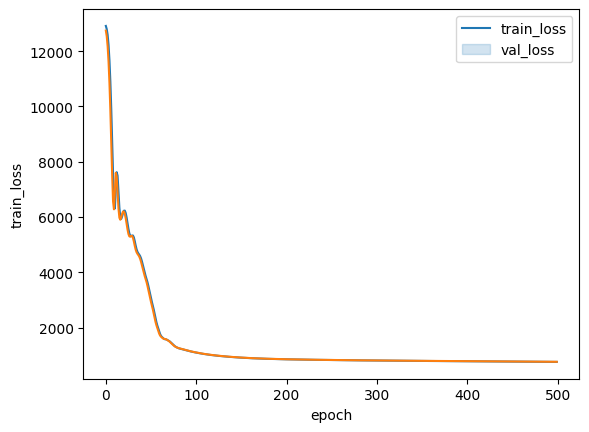

In [ ]:
#importing library
import matplotlib.pyplot as plt
import seaborn as sns

#converting the train and validation loss to a df
trainhist = pd.DataFrame({'train_loss': train_loss, 'val_loss': valadition_loss, 'epoch':np.arange(num_epochs)})
#plotting training loss
sns.lineplot(x='epoch', y ='train_loss', data =trainhist)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])

From the graph we can see that...
+ There is not a huge gap between the training and validation loss.
+ The training and validation loss decreased and then became constant as the number of epochs increased.
It appears that the model is not underfitting nor overfitting.

Let's also look at the MSE for this model.

In [ ]:
#calculating MSE for model
y_pred = model(X_test).detach().numpy()
print(f'MSE: {round(mean_squared_error(y_test,y_pred),4)}')

MSE: 760.4901


##8.Can you improve the model performance by adding more layers and using dropout? Please justify your answer by providing the codes and model outputs.

Our model is neither under-fitting nor over-fitting but let's see if adding more layers and using drop out can improve the model's performance even further. Our new model will be built with the following layers using PyTorch:
* First Hidden Layer: 20 Neurons
* First Droupout Layer Rate: 0.3
* Second Hidden Layer: 10 Neurons
* Second Droupout Layer Rate: 0.3
* Third Hidden Layer: 5 Neurons
* Output Layer: 1 Neuron

In [ ]:
#defining new model class with more layers and using drop out to model
class LinearRegressionModel(torch.nn.Module):
  #creating the neural network layers function
  def __init__(self, input_size,  hidden_size, output_size, droprate):
    #initializing the model
    super(LinearRegressionModel, self).__init__()
    #creating hidden layer 1
    self.hidden1 = torch.nn.Linear(input_size, hidden_size[0]) 
    #adding drop out for hidden layer 1
    self.hidden1_drop = nn.Dropout(droprate) 
    #creating hidden layer 2
    self.hidden2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
    #adding drop out for hidden layer 2
    self.hidden2_drop = nn.Dropout(droprate) 
    #creating hidden layer 3
    self.hidden3 = torch.nn.Linear(hidden_size[1], hidden_size[2]) 
    #creating output layer
    self.predict = torch.nn.Linear(hidden_size[2], output_size) 
  #creating the forward function
  def forward(self, x):
    x = F.relu(self.hidden1_drop(self.hidden1(x))) 
    x = F.relu(self.hidden2_drop(self.hidden2(x))) 
    x = F.relu(self.hidden3(x))
    y_pred = self.predict(x)            
    return y_pred

#since we will have three hidden layers, we need to specify the number of neurons in each layer
hidden_size = [20, 10, 5]

#we are also adding a drop out layer, so let's specify the rate
droprate = 0.3
#creating model object w/drop out parameter
model = LinearRegressionModel(input_size, hidden_size, output_size, droprate)

#specifying the loss function -- MSE
l = nn.MSELoss()

#specifying the optimization algorithm -- Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

Now, let's train the new model.

In [ ]:
%%time
#setting the number of epochs
num_epochs = 500

#tracking the training and validation loss
train_loss = [None]*num_epochs
valadition_loss = [None]*num_epochs

#looping over the epochs
for epoch in range(num_epochs):
  #forward pass using the model class we created earlier and the training dataset
  y_pred = model(X_train.requires_grad_())
  #calculating the loss 
  loss= l(y_pred, y_train)
  #setting the gradients of the Adam optimizer to equal zero
  optimizer.zero_grad()
  #backward pass
  loss.backward()
  #updating the weights using the optimizer, gradients, and current weights
  optimizer.step()
  #forecasting based on X_test
  y_pred = model(X_test).detach().numpy()
  #calculating validation loss using MSE
  val_loss = mean_squared_error(y_test,y_pred)
  #saving the loss history
  train_loss[epoch] = loss.item()
  valadition_loss[epoch] = val_loss
  #printing out loss every 10 losses
  if epoch % 10 == 0:
    print(f'epoch {epoch}, loss = {round(loss.item(), 4)} and val_loss = {round(val_loss,4)}')



epoch 0, loss = 12973.083 and val_loss = 12844.2597
epoch 10, loss = 8419.124 and val_loss = 7474.3991
epoch 20, loss = 6281.2085 and val_loss = 6125.2864
epoch 30, loss = 5555.6504 and val_loss = 5426.4131
epoch 40, loss = 3906.0842 and val_loss = 3798.5542
epoch 50, loss = 2694.1013 and val_loss = 2690.9308
epoch 60, loss = 2373.7632 and val_loss = 2350.6908
epoch 70, loss = 2177.0911 and val_loss = 2162.2866
epoch 80, loss = 2082.3025 and val_loss = 2085.8265
epoch 90, loss = 1989.674 and val_loss = 1997.9188
epoch 100, loss = 1909.363 and val_loss = 1895.9225
epoch 110, loss = 1844.6781 and val_loss = 1845.3921
epoch 120, loss = 1772.4004 and val_loss = 1768.3872
epoch 130, loss = 1711.7041 and val_loss = 1708.9893
epoch 140, loss = 1648.0635 and val_loss = 1629.1353
epoch 150, loss = 1577.7266 and val_loss = 1557.4266
epoch 160, loss = 1498.8463 and val_loss = 1502.6985
epoch 170, loss = 1426.6049 and val_loss = 1434.4281
epoch 180, loss = 1399.0682 and val_loss = 1383.7912
epoch 

Let's evaluate the model by looking at the model's history.

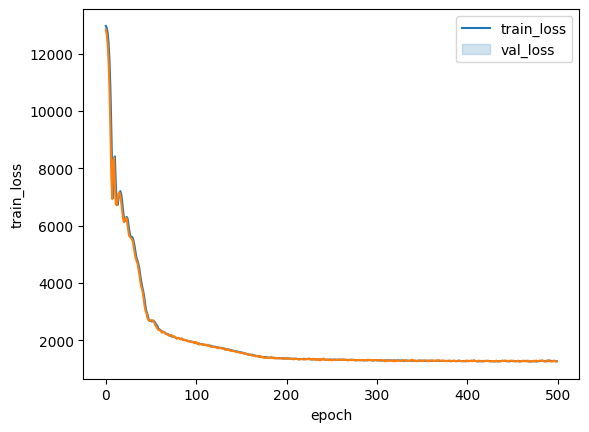

In [ ]:
#converting the train and validation loss to a df
trainhist = pd.DataFrame({'train_loss': train_loss, 'val_loss': valadition_loss, 'epoch':np.arange(num_epochs)})
#plotting training loss
sns.lineplot(x='epoch', y ='train_loss', data =trainhist)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])

Looking at the graph, we can see that...
+ There is not a huge gap between the training and validation loss.
+ The training and validation loss decreased and then become constant as the number of epochs increased.
It appears that the model is not underfitting nor overfitting.

If we compared the first graph to the second graph, we can see that they look similar, so let's look at the model's MSE to determine which model is better.

In [ ]:
#calculating MSE for model
y_pred = model(X_test).detach().numpy()
print(f'MSE: {round(mean_squared_error(y_test,y_pred),4)}')

MSE: 1268.8423


Both models fit the data decently because they neither underfit nor overfit the data. The MSE of the first model (MSE=760.4901) is less than the MSE of the second model (MSE=1268.8423), so we would recommend company to use the second model to forecast PM2.5.